In [3]:
!pip install FlowCal

     |████████████████████████████████| 82 kB 236 kB/s eta 0:00:011
     |████████████████████████████████| 103 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 8.1 MB/s eta 0:00:01
  Created wheel for FlowCal: filename=FlowCal-1.3.0-py3-none-any.whl size=84554 sha256=f8538aa8476c7b34d7891fce2ddf778dad812a3f1352f53248c7970d97b35722
  Stored in directory: /root/.cache/pip/wheels/59/b3/d2/c263ebe3ccd5e34236aeb7b9aa4285ecdb9e91587c9c959e2a
Successfully built FlowCal


In [8]:

### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib 
from matplotlib import pyplot as plt
import random
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import FlowCal
import keras
from keras.utils import Sequence
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

from keras import backend as K
import tensorflow as tf

In [16]:
data_dir = "../input/levine/"
levine_fn = data_dir + "Levine_32dim_notransform.fcs"
levine = FlowCal.io.FCSData(levine_fn)

# Find relevant labels
print(levine.shape)
print(levine.channels)
# Columns 4-36 (0-indexed) are relevant markers
# column 39 (0-indexed) is labels

# 60% of the dataset is garbage
non_garbage_idx = np.where(np.isnan(levine[:, 39]) == False)
levine = levine[non_garbage_idx]

labels = np.array(levine[:, 39], dtype=int)

levine = levine[:, 4:36]
print(levine.shape)
print(levine.channels)

# Transform data with arcsinh
levine = np.arcsinh(np.array(levine))

(265627, 41)
('Time', 'Cell_length', 'DNA1', 'DNA2', 'CD45RA', 'CD133', 'CD19', 'CD22', 'CD11b', 'CD4', 'CD8', 'CD34', 'Flt3', 'CD20', 'CXCR4', 'CD235ab', 'CD45', 'CD123', 'CD321', 'CD14', 'CD33', 'CD47', 'CD11c', 'CD7', 'CD15', 'CD16', 'CD44', 'CD38', 'CD13', 'CD3', 'CD61', 'CD117', 'CD49d', 'HLA-DR', 'CD64', 'CD41', 'Viability', 'file_number', 'event_number', 'label', 'individual')
(104184, 32)
('CD45RA', 'CD133', 'CD19', 'CD22', 'CD11b', 'CD4', 'CD8', 'CD34', 'Flt3', 'CD20', 'CXCR4', 'CD235ab', 'CD45', 'CD123', 'CD321', 'CD14', 'CD33', 'CD47', 'CD11c', 'CD7', 'CD15', 'CD16', 'CD44', 'CD38', 'CD13', 'CD3', 'CD61', 'CD117', 'CD49d', 'HLA-DR', 'CD64', 'CD41')


In [14]:
"""
Build the simplest possible decoder & encoder
Feed Forward NN with 2 layers

"""
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'

AE2layer = Sequential()
AE2layer.add(Dense(2, input_dim=32, activation="selu", name="encoder"))
AE2layer.add(Dense(32, name="decoder"))
AE2layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_2layer = AE2layer.fit(levine, levine, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=10)

Epoch 1/10
3256/3256 [==============================] - 4s 989us/step - loss: 2.4893 - mse: 2.4893
Epoch 2/10
3256/3256 [==============================] - 3s 989us/step - loss: 1.0890 - mse: 1.0890
Epoch 3/10
3256/3256 [==============================] - 3s 1ms/step - loss: 1.0679 - mse: 1.0679
Epoch 4/10
3256/3256 [==============================] - 3s 1ms/step - loss: 1.0301 - mse: 1.0301
Epoch 5/10
3256/3256 [==============================] - 3s 979us/step - loss: 0.9770 - mse: 0.9770
Epoch 6/10
3256/3256 [==============================] - 3s 1ms/step - loss: 0.9307 - mse: 0.9307
Epoch 7/10
3256/3256 [==============================] - 3s 1ms/step - loss: 0.9088 - mse: 0.9088
Epoch 8/10
3256/3256 [==============================] - 3s 978us/step - loss: 0.8998 - mse: 0.8998
Epoch 9/10
3256/3256 [==============================] - 3s 1ms/step - loss: 0.8989 - mse: 0.8989
Epoch 10/10
3256/3256 [==============================] - 3s 985us/step - loss: 0.8980 - mse: 0.8980


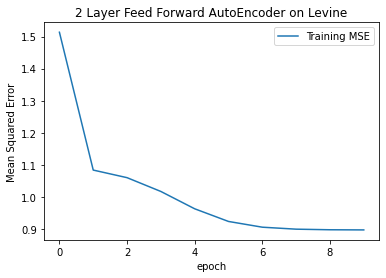

In [15]:
"""
Simplest FF Autoencoder metrics
It seems to overfit, makes sense that it does.
"""

plt.figure(1)
plt.plot(history_2layer.history["loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("2 Layer Feed Forward AutoEncoder on Levine")
plt.savefig("2layerMetrics_levine")

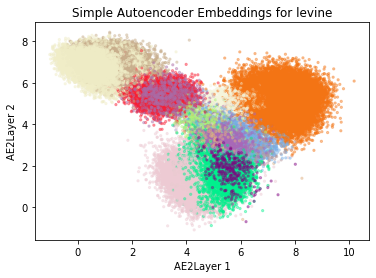

In [17]:
"""
Embeddings generated by simplest FF Model
"""
simple_encoder = AE2layer.get_layer("encoder")
levine_encoding = simple_encoder(levine)

#labels = np.array(pd.read_csv(data_dir + "population_assignmentlevine.csv")["Population"])
#print(labels)

color_list = ["beige", "violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure(2)
plt.scatter(levine_encoding[:, 0], levine_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE2Layer 1")
plt.ylabel("AE2Layer 2")
plt.title("Simple Autoencoder Embeddings for levine")
plt.savefig("2 layer AE embeddings levine")

np.save("levine_2layer", levine_encoding)

In [19]:
"""
Add a few layers to the network, see how it changes embeddings
Still a simple FF model

"""
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'

AE6layer = Sequential()
AE6layer.add(Dense(20, input_dim=32, activation="selu", name="encoder1"))
AE6layer.add(Dense(10, activation="selu", name="encoder2"))
AE6layer.add(Dense(2, activation="selu", name="encoder3"))
AE6layer.add(Dense(10, activation="selu", name="decoder1"))
AE6layer.add(Dense(20, activation="selu", name="decoder2"))
AE6layer.add(Dense(32, name="decoder3"))
AE6layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_6layer = AE6layer.fit(levine, levine,
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=20)

Epoch 1/20
3256/3256 [==============================] - 5s 1ms/step - loss: 1.7468 - mse: 1.7468
Epoch 2/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.8140 - mse: 0.8140
Epoch 3/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.7051 - mse: 0.7051
Epoch 4/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6678 - mse: 0.6678
Epoch 5/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6430 - mse: 0.6430
Epoch 6/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6261 - mse: 0.6261
Epoch 7/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6198 - mse: 0.6198
Epoch 8/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6136 - mse: 0.6136
Epoch 9/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6089 - mse: 0.6089
Epoch 10/20
3256/3256 [==============================] - 4s 1ms/step - loss: 0.6047 - mse: 0.6047
Epoch 11/20
3256/3256 [======

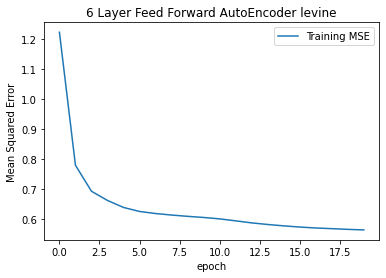

In [20]:
"""
6 layer FF Autoencoder metrics
It also seems to overfit, but it did much better than the 2 layer model.
"""

plt.figure(1)
plt.plot(history_6layer.history["loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("6 Layer Feed Forward AutoEncoder levine")
plt.savefig("6layerMetrics_levine")

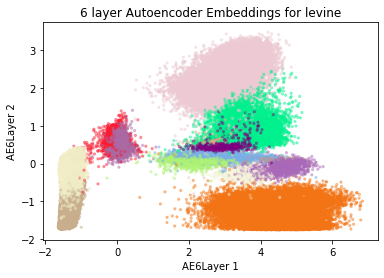

In [21]:
"""
Embeddings generated by 6 layer
"""

e1 = AE6layer.get_layer("encoder1")
e2 = AE6layer.get_layer("encoder2")
e3 = AE6layer.get_layer("encoder3")
levine_encoding = e3(e2(e1(levine)))

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(levine_encoding[:, 0], levine_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE6Layer 1")
plt.ylabel("AE6Layer 2")
plt.title("6 layer Autoencoder Embeddings for levine")
plt.savefig("6 layer AE embeddings levine")

np.save("levine_6layer", levine_encoding)

In [22]:
def rec_loss(y_true, y_pred):
    """ Reconstruction error """

    return K.sum(K.square(y_true - y_pred))


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'    

stdev = 1
    
x = Input(shape=(32,), name="input")
E1 = Dense(20, activation="selu", name="E1")(x)
E2 = Dense(10, activation="selu", name="E2")(E1)
mu = Dense(2, name="mu")(E2)
log_var = Dense(2, name="log_var")(E2)

KL = KLDivergenceLayer(name="KL")([mu, log_var])
sigma = Lambda(lambda t: K.exp(.5*t), name="sigma")(log_var)

z_eps = Multiply(name="z_eps")([sigma, K.random_normal(stddev=stdev,shape=(K.shape(x)[0], 2))])
z = Add(name="z")([mu, z_eps]) # not zeps

D1 = Dense(10, activation="selu", name="D1")(z)
D2 = Dense(20, activation="selu", name="D2")(D1)
D3 = Dense(32, name="D3")(D2)

VAE = Model(inputs=x, outputs=D3)
VAE.compile(loss=rec_loss, optimizer="adam", metrics=["mse"])

VAE_history = VAE.fit(levine, levine,
                      use_multiprocessing=True,
                      workers=-1,
                      epochs=20,
                      shuffle=True)


Epoch 1/20
3256/3256 [==============================] - 5s 1ms/step - loss: 1652.5835 - mse: 1.6139
Epoch 2/20
3256/3256 [==============================] - 4s 1ms/step - loss: 749.3343 - mse: 0.7318
Epoch 3/20
3256/3256 [==============================] - 4s 1ms/step - loss: 686.5219 - mse: 0.6704
Epoch 4/20
3256/3256 [==============================] - 4s 1ms/step - loss: 654.6447 - mse: 0.6393
Epoch 5/20
3256/3256 [==============================] - 4s 1ms/step - loss: 638.5925 - mse: 0.6236
Epoch 6/20
3256/3256 [==============================] - 4s 1ms/step - loss: 617.1528 - mse: 0.6027
Epoch 7/20
3256/3256 [==============================] - 4s 1ms/step - loss: 604.2167 - mse: 0.5901
Epoch 8/20
3256/3256 [==============================] - 4s 1ms/step - loss: 592.7835 - mse: 0.5789
Epoch 9/20
3256/3256 [==============================] - 4s 1ms/step - loss: 582.7200 - mse: 0.5691
Epoch 10/20
3256/3256 [==============================] - 4s 1ms/step - loss: 573.2318 - mse: 0.5598
Epoch 11

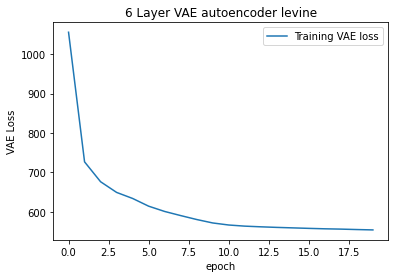

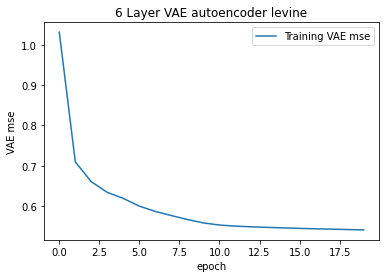

In [23]:
"""
6 layer VAE Autoencoder metrics
"""

plt.figure(1)
plt.plot(VAE_history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("VAE Loss")
plt.legend(["Training VAE loss", "Validation VAE loss"])
plt.title("6 Layer VAE autoencoder levine")
plt.savefig("VAELoss levine")

plt.figure(2)
plt.plot(VAE_history.history["mse"])
plt.xlabel("epoch")
plt.ylabel("VAE mse")
plt.legend(["Training VAE mse", "Validation VAE mse"])
plt.title("6 Layer VAE autoencoder levine")
plt.savefig("VAEMSE levine")

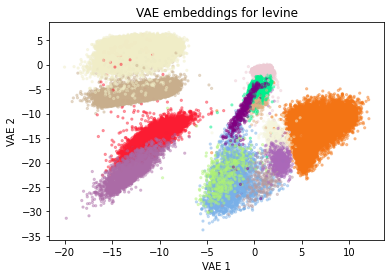

In [24]:
"""
Embeddings generated by VAE 6 layer
"""
e1 = VAE.get_layer("E1")
e2 = VAE.get_layer("E2")
e3 = VAE.get_layer("mu")
levine_mu = e3(e2(e1(levine)))

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(levine_mu[:, 0], levine_mu[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("VAE 1")
plt.ylabel("VAE 2")
plt.title("VAE embeddings for levine")
plt.savefig("VAE embeddings levine")

np.save("levine_vae", levine_mu)